#<CENTER> Test :Classifiation des images de béton, avec ou sans fissures </CENTER>

---






nous avons travaillé sur un dataset d'images de béton, fournies avec ou sans fissures. Notre objectif était de créer un classifieur capable de distinguer les images avec fissures de celles sans fissures.

In [1]:
# pour accéder aux fichiers stockés sur Google Drive directement depuis l'environnement de développement de Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#  importation des libraires  nécessaires pour l'exécution du code. 
import warnings
warnings.filterwarnings('ignore')

import os
import random
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


# Import Torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
import torchvision.models as models


from torch.utils.data import TensorDataset,Dataset, DataLoader
from torchvision import datasets, transforms

from torchvision import transforms


# Exploration et analyse succincte du dataset
nous avons procédé à une exploration et une analyse succincte du dataset. Cela nous a permis de mieux comprendre les caractéristiques des images, ainsi que les éventuelles difficultés que nous pourrions rencontrer.

In [4]:
# définition du chemin d'accès au dossier contenant notre dataset
data_path = "/content/drive/MyDrive/Dataset_test_PS"
classes = os.listdir(data_path)
classes

['Positive', 'Negative']

In [5]:
# définition du chemin d'accès au dossier de chaque classe

positive_folder =os.path.join(data_path,classes[0])
negative_folder = os.path.join(data_path,classes[1])



1.   Lecture des images à partir des dossiers contenant les images positives et négatives  à l'aide  de la bibliothèque OpenCV. Si l'image est lue avec succès, elle est redimensionnée à (224,224) 
2.   Les images lues sont ensuite stockées dans des listes distinctes en fonction de leur classe (positive ou négative) et les étiquettes correspondantes sont stockées dans une liste 'labels'


In [7]:
IM_WIDTH = IM_HEIGHT = 224 # pour unifier la taille des images
# Lire les images négatives
labels= []
positive_images = []
for filename in os.listdir(positive_folder):
    img = cv2.imread(os.path.join(positive_folder, filename))
    if img is not None:
        img = cv2.resize(img, (IM_WIDTH, IM_HEIGHT))
        positive_images.append(img)
        labels.append(1)

# Lire les images négatives
negative_images = []
for filename in os.listdir(negative_folder):
    img = cv2.imread(os.path.join(negative_folder, filename))
    if img is not None:
        img = cv2.resize(img, (IM_WIDTH, IM_HEIGHT))
        negative_images.append(img)
        labels.append(0)

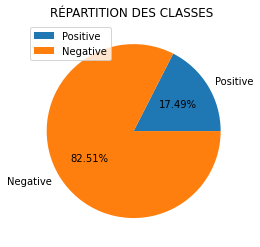

Nombre d'images positives : 825
Nombre d'images négatives : 3892


In [8]:
#affichage de nombre d'exemples dans chaque classe (images avec fissures et images sans fissures)

number_class = np.array([len(positive_images),len(negative_images)])
plt.pie(number_class, labels = classes, autopct='%1.2f%%')
plt.title('RÉPARTITION DES CLASSES ')
plt.legend()
plt.show()
print("Nombre d'images positives :", len(positive_images))
print("Nombre d'images négatives :", len(negative_images))

Remarque ❎ : On peut remarquer que le dataset n'est pas équilibré car le nombre d'images négatives est beaucoup plus élevé que le nombre d'images positives. Il est donc nécessaire d'équilibrer le dataset avant de procéder à l'entraînement du modèle de classification.

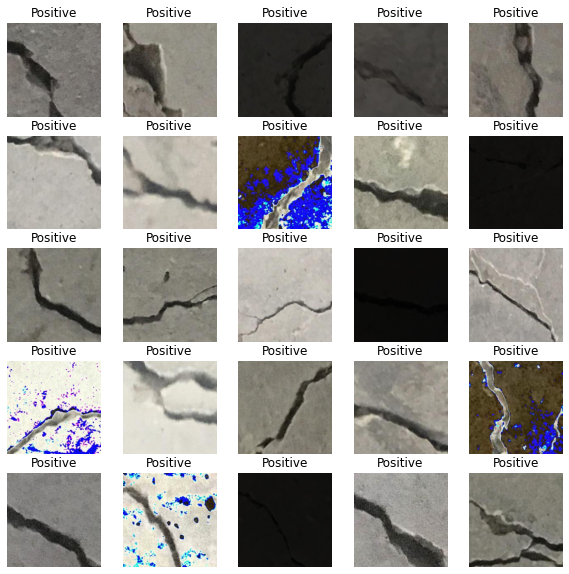

In [9]:
# Afficher un échantillon d'images POSITIVES
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(cv2.cvtColor(positive_images[i], cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Positive" if labels[i] else "Negative")
plt.show()

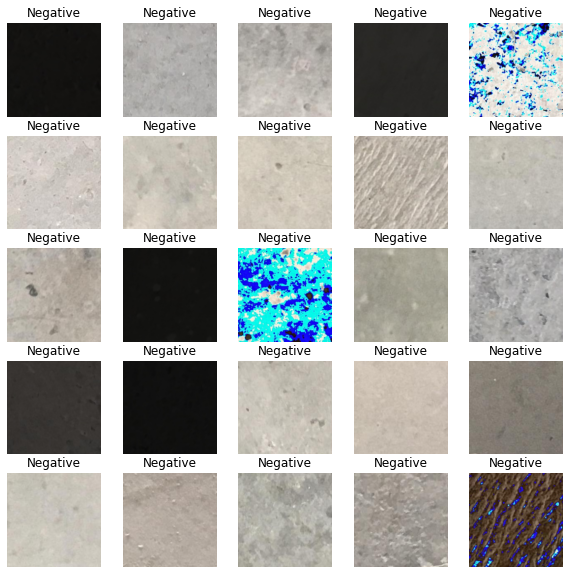

In [10]:
# Afficher un échantillon d'images negatives
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(cv2.cvtColor(negative_images[i], cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Negative" if labels[i] else "Positive")
plt.show()

Les caractéristiques descriptives calculées pour chaque classe peuvent être utilisées pour comprendre les différences entre les deux classes. Par exemple, si la moyenne de la luminosité des imags positives est  plus élevée que celle des images négatives, cela pourrait indiquer que les images positives ont tendance à être prises dans des environnements plus lumineux ou avec une plus grande quantité de lumière naturelle.



In [12]:
positive_histograms = []

# Calcule l'histogramme de chaque image positive à l'aide de la fonction 'cv2.calcHist
for img in positive_images:
    histogram = cv2.calcHist([img], [0], None, [256], [0, 256])
    positive_histograms.append(histogram)
positive_histograms = np.array(positive_histograms)

negative_histograms = []

# Calcule l'histogramme de chaque image négative à l'aide de la fonction 'cv2.calcHist

for img in negative_images:
    histogram = cv2.calcHist([img], [0], None, [256], [0, 256])
    negative_histograms.append(histogram)
negative_histograms = np.array(negative_histograms)

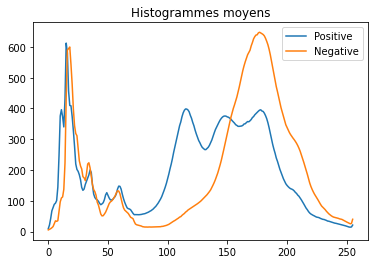

In [13]:
# Afficher les histogrammes moyens des images positives et négatives
mean_positive_histogram = np.mean(positive_histograms, axis=0)
mean_negative_histogram = np.mean(negative_histograms, axis=0)
plt.plot(mean_positive_histogram, label="Positive")
plt.plot(mean_negative_histogram, label="Negative")
plt.legend()
plt.title("Histogrammes moyens")
plt.show()

In [14]:
#calcule de la moyenne et l'écart type des pixels de l'ensemble de données d'images positives 
mean1 = np.mean(positive_images, axis=(0, 1, 2)) / 255
std1 = np.std(positive_images, axis=(0, 1, 2)) / 255
#calcule de la moyenne et l'écart type des pixels de l'ensemble de données d'images positives 
mean2 = np.mean(negative_images, axis=(0, 1, 2)) / 255
std2= np.std(negative_images, axis=(0, 1, 2)) / 255
print(f"Positive images :moy ={mean1} et ecart type = {std1}")
print(f"Négative images :moy ={mean2} et ecart type = {std2}")



Positive images :moy =[0.47581933 0.5017547  0.51204221] et ecart type = [0.24291938 0.25405125 0.25962934]
Négative images :moy =[0.56407441 0.58358643 0.59594491] et ecart type = [0.25876113 0.26992961 0.27632123]


# Préparation du dataset pour le Train


## Equilibration de classes
Après avoir effectué la phase d'analyse du dataset, nous avons constaté que le nombre d'images positives était de 825 tandis que le nombre d'images négatives était de 3892, ce qui suggère un déséquilibre important entre les deux classes.

Ce déséquilibre peut avoir un impact négatif sur la performance de notre modèle; Afin de remédier à ce problème, nous avons décidé de procéder à l'augmentation des exemples de la classe minoritaire en utilisant des techniques d'augemntation de Pytorch :

*   rotation
*   changement d'échelle

In [15]:
# Ajout des images augmentées à la liste des images positives
# Créer une liste vide pour stocker les nouvelles images de classe positive

new_positive_images = []
# Les transformations à appliquer aux images pour l'augmentation des données

transformations_positve = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(90),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomRotation(120),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
])

In [16]:
for img in positive_images:
  for i in range (4):
    transformed_image = transformations_positve(img)
    new_positive_images.append(np.asarray(transformed_image))

l'image Orginal  numéro: 1 avant augemntation


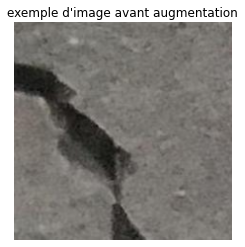

In [17]:
img_index = 0
print(f"l'image Orginal  numéro: {img_index+1} avant augemntation")
plt.figure()
plt.imshow(cv2.cvtColor(positive_images[img_index], cv2.COLOR_BGR2RGB))
plt.title("exemple d'image avant augmentation")
plt.axis("off")
plt.show()

les 4 variation pour l'augemntation apliqué à image n : 0


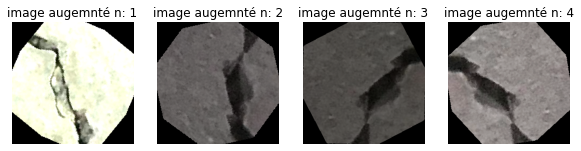

In [18]:
print("les 4 variation pour l'augemntation apliqué à image n : {}".format(img_index))
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(cv2.cvtColor(new_positive_images[i-1], cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("image augemnté n: "+str(i+1))
plt.show()

In [19]:
number = len(negative_images) - len(positive_images)
positive_images = np.concatenate((positive_images, new_positive_images[:number]), axis=0)
len(positive_images)

3892

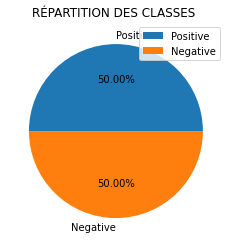

Nombre d'images positives : 3892
Nombre d'images négatives : 3892


In [20]:
number_class = np.array([len(positive_images),len(negative_images)])
plt.pie(number_class, labels = classes, autopct='%1.2f%%')
plt.title('RÉPARTITION DES CLASSES ')
plt.legend()
plt.show()
print("Nombre d'images positives :", len(positive_images))
print("Nombre d'images négatives :", len(negative_images))

## Séparetion de l'ensemble d'apprentissage et de test


In [28]:
## Séparetion de l'ensemble d'apprentissage et de test
labels_negative = np.zeros(len(negative_images))
labels_positive = np.ones(len(positive_images))

X_data = np.concatenate((positive_images, negative_images))
y_data = np.concatenate((labels_positive, labels_negative))
print(X_data.shape)
print(y_data.shape)

(7784, 224, 224, 3)
(7784,)


In [29]:
#définit une classe CustomDataset qui hérite de la classe Dataset de PyTorch.
#pour la personnalisation du dataset
class CustomDataset(Dataset):
    def __init__(self, X_data, y_data, transform=None):
        self.X_data = X_data
        self.y_data = y_data
        self.transform = transform
        
    def __len__(self):
        return len(self.X_data)
    
    def __getitem__(self, index):
        x = self.X_data[index]
        y = self.y_data[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y


définition d'un transform_data de la classe Compose  qui sert à définir une série de transformations à appliquer aux images avant l'utulisation pour l'entraînement ou l'évaluation.
 Dans notre cas la transformation consiste à convertir les images en tenseurs à l'aide de la méthode ToTensor()

In [30]:
transform_data = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.25,0.25,0.25])
])

Nous divisons la taille totale du dataset en trois parties: une partie pour l'entraînement, une partie pour la validation et une partie pour les tests. Les tailles des trois ensembles sont déterminées en fonction des proportions fixées : 70% pour l'ensemble d'entraînement, 20% pour l'ensemble de validation et 10% pour l'ensemble de test

In [31]:

train_size = int(0.7 * len(X_data))
valid_size = int(0.2 * len(X_data))
test_size = len(X_data) - train_size - valid_size

#Instanciation de la claas CustomDataset et app des transformation transform_data définie précédemment
custom_dataset = CustomDataset(X_data, torch.LongTensor(y_data), transform=transform_data)
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(custom_dataset,[train_size, valid_size, test_size])


Création  des objet dataloaders de type torch.utils.data.DataLoader qui sera en charge de générer les batchs ( pour train , valid , Test). Nous paramétrons le DataLoader pour des batchs de 32 images mélangées aléatoirement.

In [32]:

# Create dataloaders for the training, validation, and test sets
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [35]:
print(f"train size: {len(train_dataset)} validation size: {len(valid_dataset)} test size :{len(test_dataset)}")

train size: 5448 validation size: 1556 test size :780


Chargement du résultat du premier batch par la méthode "next" pour s'assurer que les dimensions et la taille de notre tenseur sont correctes et que la normalisation est bien appliquée.

In [39]:
X_batch, classes = next(iter(train_dataloader))
print(f"taille du premier batch : {X_batch.size()}")
print("*"*50)
print(f"type de data :{X_batch[0].dtype}")
print("*"*50)
print(f"taille d'une image dans le batch :{X_batch[0].size()}")
print("*"*50)
print(f"type de data :{classes.dtype}")
print("*"*50)
print(f"classes des 32 images  :{classes}")
print("*"*50)
print(f"exemple d'une image normalisé :{X_batch[0]}")


taille du premier batch : torch.Size([32, 3, 224, 224])
**************************************************
type de data :torch.float32
**************************************************
taille d'une image dans le batch :torch.Size([3, 224, 224])
**************************************************
type de data :torch.int64
**************************************************
classes des 32 images  :tensor([1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 1, 0])
**************************************************
exemple d'une image normalisé :tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
        

# Classification

## resnet18
Le réseau que nous allons utiliser est un ResNet18 (à 18 couches) dont l'architecture est la suivante :



Nous allons utiliser ce réseau pré-entrainé sur la base ImageNet. Nous allons supprimer la dernière couche du réseau pré-entrainé et la remplacer par une nouvelle couche entièrement connectée à num_classes=2 sorties  Nous entrainerons uniquement cette nouvelle couche pour limiter les temps de calcul. 

In [45]:
class MyResNet18(nn.Module):
    def __init__(self, num_classes):
        super(MyResNet18, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x

Nous définissons la fonction train pour lancer l'apprentissage de la dernière couche du réseau et pour organiser notre code. Les commentaires du code expliquent chaque ligne de la fonction.

In [46]:
def train(model, dataloader, criterion, optimizer, device):
    #activation du mode training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    # Iteration sur les données de train
    for images, labels in dataloader:
        #envoi des données sur le GPU
        images, labels = images.to(device), labels.to(device) 
        # mise à 0 des gradients
        optimizer.zero_grad()
        # prédiction du réseau pour les images
        outputs = model(images)
        # estimation de la fonction de cout
        loss = criterion(outputs, labels)
        # backward + optimisation du réseau
        # Calcul des gradients
        loss.backward()
        # Application de la mise à jours des poids
        optimizer.step()
        # statistique
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

Nous définissons la fonction validate pour évaluer les performances du modèle sur l'ensemble de validation sans effectuer de calculs de gradients. Cela permet d'éviter la rétropropagation du gradient sur les couches précédentes. Les commentaires du code expliquent chaque ligne de la fonction.

In [48]:
def validate(model, dataloader, criterion, device):
    # Mode evaluation
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

Nous définissons la fonction evaluate pour évaluer les performances du modèle sur l'ensemble de test en calculant l'accuracy et la matrice de confusion. Les commentaires du code expliquent chaque ligne de la fonction.

In [49]:
def evaluate(model, dataloader, device):
    model.eval()
    all_labels = np.array([], dtype=int)
    all_preds = np.array([], dtype=int)
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels = np.concatenate((all_labels, labels.cpu().numpy()))
            all_preds = np.concatenate((all_preds, predicted.cpu().numpy()))
    acc = np.mean(all_labels == all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    return acc, cm

In [50]:
#  les éléments du modèle en carte graphique if available 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# notre probléme deux classes
num_classes = 2

# Definir notre model, criterion, and optimizer
model = MyResNet18(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



Using device: cuda:0


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [51]:
# Train 
train_losses,valid_losses = [],[]
train_accs,valid_accs = [],[]
num_epochs = 20

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_loss, valid_acc = validate(model, valid_dataloader, criterion, device)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    print(f"Epoch {epoch+1}: train loss={train_loss:.4f}, train acc={train_acc:.4f}, valid loss={valid_loss:.4f}, valid acc={valid_acc:.4f}")

Epoch 1: train loss=0.1448, train acc=0.9503, valid loss=0.0794, valid acc=0.9775
Epoch 2: train loss=0.0825, train acc=0.9738, valid loss=0.0907, valid acc=0.9737
Epoch 3: train loss=0.0618, train acc=0.9793, valid loss=0.0608, valid acc=0.9807
Epoch 4: train loss=0.0527, train acc=0.9827, valid loss=0.0635, valid acc=0.9820
Epoch 5: train loss=0.0506, train acc=0.9826, valid loss=0.0699, valid acc=0.9826
Epoch 6: train loss=0.0465, train acc=0.9855, valid loss=0.1552, valid acc=0.9640
Epoch 7: train loss=0.0483, train acc=0.9849, valid loss=0.0697, valid acc=0.9814
Epoch 8: train loss=0.0463, train acc=0.9857, valid loss=0.0538, valid acc=0.9859
Epoch 9: train loss=0.0365, train acc=0.9892, valid loss=0.0682, valid acc=0.9852
Epoch 10: train loss=0.0791, train acc=0.9750, valid loss=0.0691, valid acc=0.9801
Epoch 11: train loss=0.0582, train acc=0.9820, valid loss=0.0560, valid acc=0.9852
Epoch 12: train loss=0.0454, train acc=0.9862, valid loss=0.0721, valid acc=0.9807
Epoch 13: tra

**Résultat** ⚡: En examinant les résultats d'entraînement et de validation du modèle ResNet18 pour 20 epochs, nous pouvons conclure que le modèle a été bien entraîné avec une perte d'entraînement très faible et une précision de 98,77 % sur les données d'entraînement et une perte de validation faible avec une précision de 98,01 % sur les données de validation.
 Cela indique que notre modèle a appris les feautres importantes des données d'entraînement , ainsi il a généralisé avec succès sur les données de validation. 

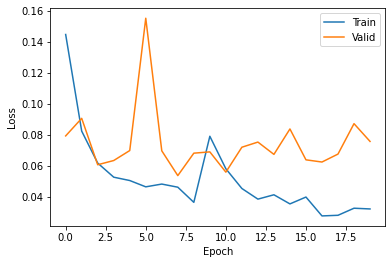

In [52]:
def plot_loss(train_losses, valid_losses):
    plt.plot(train_losses, label='Train')
    plt.plot(valid_losses, label='Valid')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(train_losses, valid_losses)

Le modèle  n a pas avoir atteint sa convergence après un nombre fixe d'epochs, ce qui peut entraîner une perte qui n'est pas encore stable. Cela peut nécessiter l'entraînement du modèle pendant plus d'epochs pour atteindre la convergence et stabiliser la perte :

idées pour améliorer : 


1.   plus d'epochs avec early stopping

1.   choix hyperparamètres( le taux d'apprentissage, la taille du batch ...)

1.   ajouter une couche Dropout

1.   augmentation du data
















***Nous pouvons résumer que notre modèle fonctionne bien sur les données d'entraînement et de validation et généralise bien aux nouvelles données. Pour nous assurer de la performance de notre modèle, nous allons le tester sur les données de test pour évaluer sa capacité à généraliser***

In [53]:
torch.save(model, "PS-resnet.pkl")


In [54]:
saved_model = torch.load("PS-resnet.pkl")
saved_model.eval()

MyResNet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [60]:
acc,matrix = evaluate(model, test_dataloader, device)
print(f"Accuracy sur le test : {acc * 100}% ")

Accuracy sur le test : 98.33333333333333% 


In [61]:
def plot_Mconfusion(cm, num_classes):

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("La matrice de confusion")
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, ["positive","negative"], rotation=45)
    plt.yticks(tick_marks, ["positive","negative"])
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], "d"),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

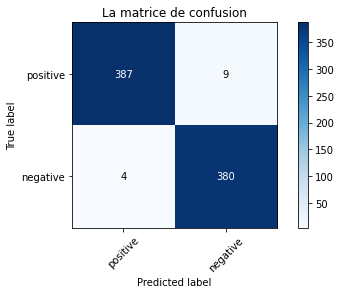

In [62]:
plot_Mconfusion(matrix,num_classes)

*Voici quelques idées et pistes que j'avais pas le temps pour faire  :*

*   **Tester d'autres modèles pré-entraînés** :En plus de ResNet18 JE VEUX essayer d'autres architectures  telles que VGG 16, InceptioV3 et faire une étude comparative pour  voir si elles offrent des performances améliorées
*   **Créer un réseau CNN personnalisé** : mon propre architecture de réseau CNN personnalisé pour cette tâche ou d'aprés des article . afin de contrôler chaque aspect de réseau et d'optimiser les performances 


*   **une analyse plus détaillée des performances de l'algorithme**: Courbe ROC ect ...

*   **Faire de la segmentation**



